# LONG SHORT TERM MEMORY MODEL

In [89]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# Load the dataset
btc_data = pd.read_csv('BTC-USD.csv')

In [90]:
# descriptions
print(btc_data.info())
print(btc_data.describe())
print('Null Values:',btc_data.isnull().values.sum())
print('NA values:',btc_data.isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2152 non-null   object 
 1   Open       2152 non-null   float64
 2   High       2152 non-null   float64
 3   Low        2152 non-null   float64
 4   Close      2152 non-null   float64
 5   Adj Close  2152 non-null   float64
 6   Volume     2152 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 117.8+ KB
None
              Open         High          Low        Close    Adj Close  \
count  2152.000000  2152.000000  2152.000000  2152.000000  2152.000000   
mean    163.156202   167.948896   157.959413   163.226687   163.226687   
std     176.929458   182.319155   170.927011   176.832260   176.832260   
min       1.511360     1.582660     1.462560     1.510360     1.510360   
25%      15.214465    15.667825    14.775683    15.227004    15.227004   
50%      30.932899   

In [91]:
# Print the start and end dates of the dataset
print("Start Date:", btc_data['Date'].iloc[0])
print("End Date:", btc_data['Date'].iloc[-1])

Start Date: 2017-11-09
End Date: 2023-09-30


In [92]:
# changing Date format
btc_data['Date'] = pd.to_datetime(btc_data['Date'], format='%Y-%m-%d')
btc_data = btc_data.loc[(btc_data['Date'] >= '2014-09-16')
                     & (btc_data['Date'] <= '2023-09-30')]
#drop 'Adj Close','Volume'
btc_data.drop(btc_data[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2017-11-09,2.053140,2.174230,1.893940,1.990770
1,2017-11-10,2.007730,2.069470,1.644780,1.796840
2,2017-11-11,1.786280,1.917750,1.614290,1.670470
3,2017-11-12,1.668890,1.672800,1.462560,1.519690
4,2017-11-13,1.526010,1.735020,1.517600,1.686620
...,...,...,...,...,...
2147,2023-09-26,210.050171,213.187820,209.866913,212.378448
2148,2023-09-27,212.371399,215.728745,210.886002,211.985413
2149,2023-09-28,211.990952,216.775330,211.651321,215.075989
2150,2023-09-29,215.093979,217.257706,214.506378,215.279419


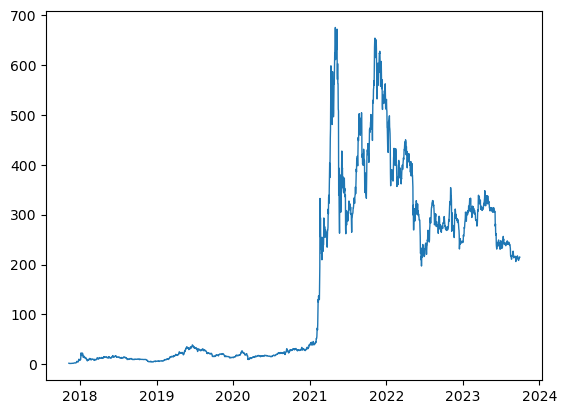

In [93]:
# plot of btc_df['Close'] 
plt.plot(btc_data['Date'], btc_data['Close'],label='Entire Dataset', linewidth=1)

In [94]:
# setting a seed
random.seed(123)
# Prepare data for training and testing 
start_train = '2014-09-17'  # Replace with the start date for training data
end_train = '2022-09-08'    # Replace with the end date for training data
train_data = btc_data.loc[(btc_data["Date"]>=start_train)&(btc_data["Date"]<=end_train)]
test_data = btc_data.loc[btc_data["Date"]>end_train]

In [95]:
# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))
scaled_test = scaler.transform(test_data['Close'].values.reshape(-1, 1))

# Preparing to convert data to sequences
def create_seq(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Set sequence length for LSTM
seq_length = 7  #  I choose 7days because human behaviour repetition per week
# Create sequences for training plus testing data
Xtrain, ytrain = create_seq(scaled_train, seq_length)
Xtest, ytest = create_seq(scaled_test, seq_length)
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [96]:
print(Xtrain)

[[[7.12590812e-04]
  [4.24934984e-04]
  [2.37490716e-04]
  ...
  [2.61445966e-04]
  [1.21956696e-04]
  [2.97994409e-05]]

 [[4.24934984e-04]
  [2.37490716e-04]
  [1.38391630e-05]
  ...
  [1.21956696e-04]
  [2.97994409e-05]
  [1.00211559e-04]]

 [[2.37490716e-04]
  [1.38391630e-05]
  [2.61445966e-04]
  ...
  [2.97994409e-05]
  [1.00211559e-04]
  [0.00000000e+00]]

 ...

 [[4.15197129e-01]
  [4.11952779e-01]
  [4.10735196e-01]
  ...
  [4.09783421e-01]
  [4.11365037e-01]
  [4.08167130e-01]]

 [[4.11952779e-01]
  [4.10735196e-01]
  [4.09250224e-01]
  ...
  [4.11365037e-01]
  [4.08167130e-01]
  [3.87374986e-01]]

 [[4.10735196e-01]
  [4.09250224e-01]
  [4.09783421e-01]
  ...
  [4.08167130e-01]
  [3.87374986e-01]
  [4.11245578e-01]]]


Epoch 1/100
110/110 [==============================] - 2s 7ms/step - loss: 0.0201 - val_loss: 0.0016
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.0630e-04
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 9.1529e-04 - val_loss: 2.7931e-04
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 8.7427e-04 - val_loss: 3.4369e-04
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 8.2354e-04 - val_loss: 4.6522e-04
Epoch 6/100
110/110 [==============================] - 0s 4ms/step - loss: 7.6915e-04 - val_loss: 5.8829e-04
Epoch 7/100
110/110 [==============================] - 0s 4ms/step - loss: 7.2827e-04 - val_loss: 5.6759e-04
Epoch 8/100
110/110 [==============================] - 0s 4ms/step - loss: 7.7076e-04 - val_loss: 2.7793e-04
Epoch 9/100
110/110 [==============================] - 0s 4ms/step - loss: 6.8709e-04 - val_loss: 2.5882e-04
Epoch 10/100
110/110 [=========

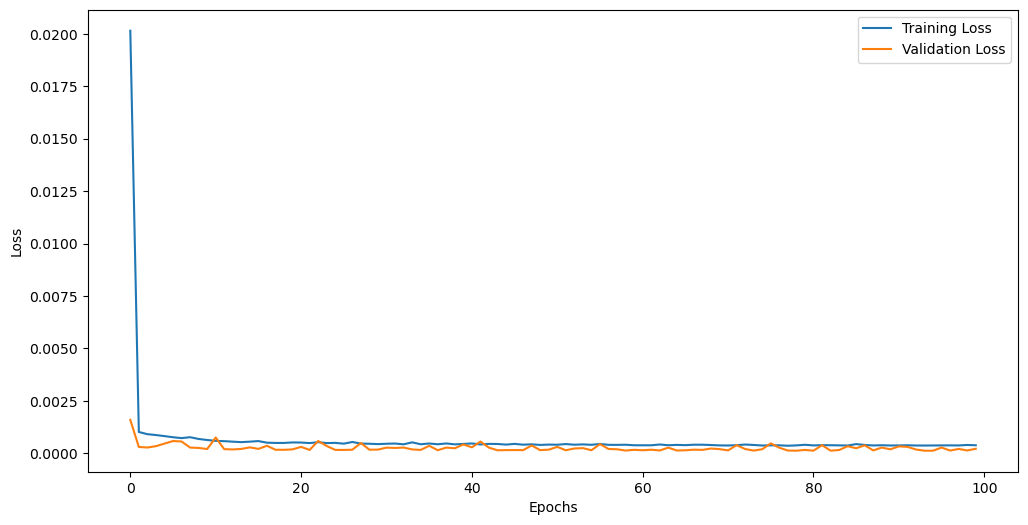

In [97]:
# Train the model
history = model.fit(Xtrain, ytrain, epochs=100, batch_size=16, validation_data=(Xtest, ytest))
# Plot Loss vs Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [98]:
# Printing the Shape
print("shape of X_train :", Xtrain.shape)
print("shape of X_test :", Xtest.shape)
print("shape of y_train : ", ytrain.shape)
print("shape of y_test :", ytest.shape)

shape of X_train : (1758, 7, 1)
shape of X_test : (380, 7, 1)
shape of y_train :  (1758, 1)
shape of y_test : (380, 1)


In [99]:
# Predictions using model
train_pred = model.predict(Xtrain)
test_pred = model.predict(Xtest)

# Inverse transform predictions to initial scale
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)



12/12 [==============================] - 0s 3ms/step


In [100]:
# Evaluation of model
rmse_train = np.sqrt(mean_squared_error(train_data['Close'].iloc[seq_length:], train_pred))
rmse_test = np.sqrt(mean_squared_error(test_data['Close'].iloc[seq_length:], test_pred))
mae_train = mean_absolute_error(train_data['Close'].iloc[seq_length:], train_pred)
mae_test = mean_absolute_error(test_data['Close'].iloc[seq_length:], test_pred)
train_r2 = r2_score(train_data['Close'].iloc[seq_length:], train_pred)
test_r2 = r2_score(test_data['Close'].iloc[seq_length:], test_pred)
mape_train = mean_absolute_percentage_error(train_data['Close'].iloc[seq_length:], train_pred)
mape_test= mean_absolute_percentage_error(test_data['Close'].iloc[seq_length:], test_pred)

# Print evaluation metrics
print("MAE of train:", mae_train)
print("MAE of Test:", mae_test)
print("RMSE of train:", rmse_train)
print("RMSE of test:", rmse_test)
print("R-squared train:", train_r2)
print("R-squared test:", test_r2)
print("MAPE for train:", mape_train)
print("MAPE for train:", mape_test)

MAE of train: 7.325760874725533
MAE of Test: 7.9525455619963
RMSE of train: 12.908556902519608
RMSE of test: 9.978842481263753
R-squared train: 0.9951525832136333
R-squared test: 0.9304726882075854
MAPE for train: 0.21013615224363208
MAPE for train: 0.029497926708395558


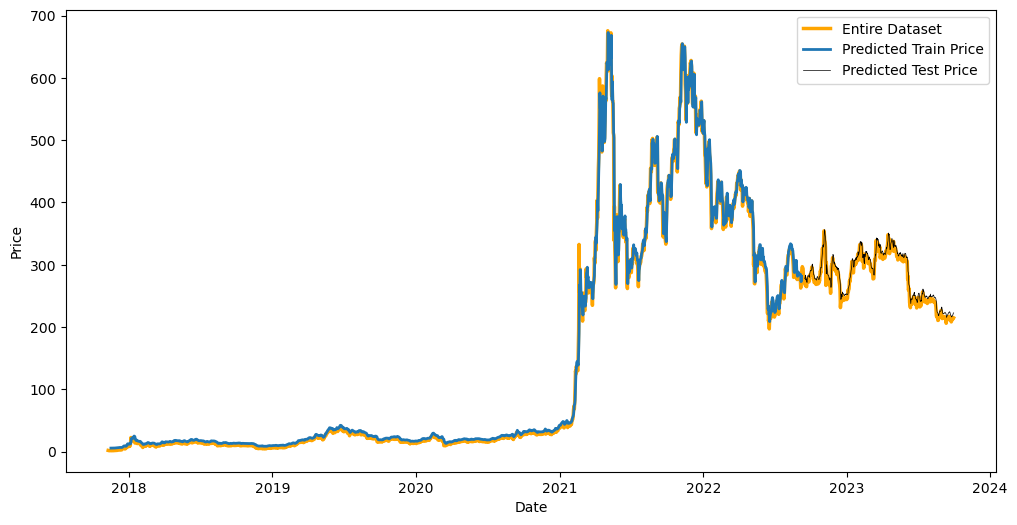

In [101]:

# Plot actual and Forecasts
plt.figure(figsize=(12, 6))
# Add the entire plot of df['Close'] 
plt.plot(btc_data['Date'], btc_data['Close'], color='orange',label='Entire Dataset', linewidth=2.5)
plt.plot(train_data['Date'].iloc[seq_length:], train_pred, linewidth=2, label='Predicted Train Price')
plt.plot(test_data['Date'].iloc[seq_length:], test_pred, color='black', linewidth=0.5, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


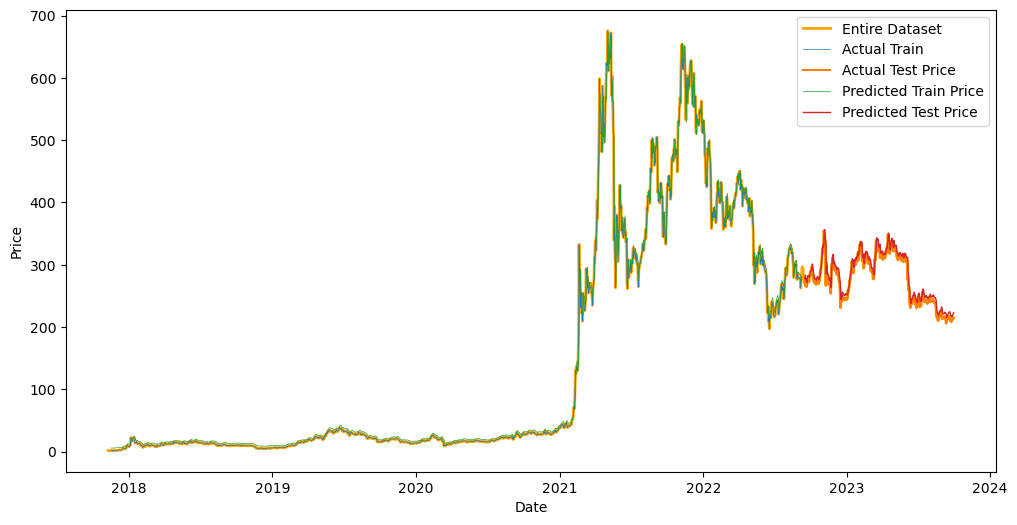

In [102]:
# Plot original vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(btc_data['Date'], btc_data['Close'], color='orange',label='Entire Dataset', linewidth=2)
plt.plot(train_data['Date'].iloc[seq_length:], train_data['Close'].iloc[seq_length:], linewidth=0.5,label='Actual Train')
plt.plot(test_data['Date'].iloc[seq_length:], test_data['Close'].iloc[seq_length:],label='Actual Test Price')
plt.plot(train_data['Date'].iloc[seq_length:], train_pred, linewidth=0.5, label='Predicted Train Price')
plt.plot(test_data['Date'].iloc[seq_length:], test_pred, linewidth=1, label='Predicted Test Price')
plt.xlabel("Date")
plt.ylabel('Price')
plt.legend()
plt.show()

In [74]:
# Create a DataFrame with test_predictions and the original df with Date as the index
result_dflstm = pd.DataFrame({
    'Date': test_data['Date'].iloc[seq_length:],
    'Initial_Close': test_data['Close'].iloc[seq_length:].values,
    'test_predictions': test_pred.flatten()
})
# Set the 'Date' column as the index
result_dflstm.set_index('Date', inplace=True)
# Print the resulting DataFrame
result_dflstm

,Initial_Close,test_predictions
Date,,
2022-09-16,0.356688,0.323893
2022-09-17,0.377004,0.344029
2022-09-18,0.358323,0.365329
2022-09-19,0.387073,0.356402
2022-09-20,0.415183,0.377179
...,...,...
2023-09-26,0.501708,0.494897
2023-09-27,0.499597,0.492139
2023-09-28,0.509525,0.490212
